# Exercise 5B - Clustering

## Group *ID* : $2207$

### Members

- Pietro Cappelli
    - e-mail: pietro.cappelli@studenti.unipd.it
    - ID: 2058332
- Alberto Coppi
    - e-mail: alberto.coppi@studenti.unipd.it
    - ID: 2053063
- Giacomo Franceschetto
    - e-mail: giacomo.franceschetto@studenti.unipd.it
    - ID: 2053348
- Nicolò Lai
    - e-mail: nicolo.lai@studenti.unipd.it
    - ID: 2064377 
### Author contribution statement

Each and every member of the group equally worked on the drafting of this notebook. 

## Import libraries and custom modules

In [ ]:
import scipy             as sp
import numpy             as np 
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from matplotlib.ticker import NullFormatter
from sklearn           import manifold, metrics
from time              import time

from sklearn.cluster         import DBSCAN
from sklearn.preprocessing   import StandardScaler
from collections             import OrderedDict
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.neighbors       import NearestNeighbors
from kneed                   import KneeLocator
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster         import AgglomerativeClustering

import scipy.stats 
import pickle

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
colors = [
    "#fd7f6f",
    "#7eb0d5",
    "#b2e061",
    "#bd7ebe",
    "#ffb55a",
    "#8bd3c7"
]

## Kullback-Leibler and Jensen-Shannon divergence

In [ ]:
def kl(p, q):
    """Kullback-Leibler divergence"""
    return sum(p*np.log(p/q))
    
def js(p, q):
    """Jensen-Shannon divergence"""
    m = (p + q) / 2.
    return (kl(p, m) + kl(q, m)) / 2.

## Probability distributions

In [ ]:
class DataGenerator: 
    """
    Class that deals with generating a set of records made of random variates 
    sampled from particular probability distributions
    """

    # define four probability distributions as class variables
    distributions = [
        sp.stats.expon(scale=2),
        sp.stats.cauchy(scale=1.5),
        sp.stats.chi2(df=2),
        sp.stats.halfnorm(loc=0, scale=2)
    ]


    def sample(self, pdf):
        """random sample one instance"""
        return pdf.rvs()
    

    def get_record(self, m = 1000, region = (1, 10)):
        """
        build the record made of `m` random variates inside a `region`
        """

        # each record has its label
        yy  = np.random.randint(low=0, high=4, size=1)[0]

        # that is connected to one probability distribution
        pdf = self.distributions[yy]

        # record empty list
        xx = []

        # generate m random variates following pdf 
        for i in range(m):

            # initial out of range sample
            x_ = 0

            # while the sample is out of range repeat the sampling
            while (x_ < region[0] or x_ > region[1]):
                x_ = self.sample(pdf=pdf)

            # append the correct sample
            xx.append(x_)

        return xx, yy

    
    def get_dataset(self, n = 8000, m = 1000, region = (1, 10)):
        """build the dataset of `n` records"""

        # dataset and labels empty lists
        x = []
        y = []

        # generate n records
        for i in range(n):
            xx, yy = self.get_record(m=m, region=region)
            x.append(xx)
            y.append(yy)

        return np.array(x), np.array(y)


## Useful functions

In [ ]:
def save_data(x, name, tag="data"):
    """save data in a .pkl file"""
    with open(f"DATA/{name}_{tag}.pkl", "wb") as f:
        pickle.dump(x, f)

def load_data(name, tag="data"):
    """load data from a .pkl file"""
    with open(f"DATA/{name}_{tag}.pkl", "rb") as f:
        x = pickle.load(f)
    return x

def binning(x, bins):
    """bin data"""
    return [np.histogram(x_i, bins=bins, density=True)[0] for x_i in x]


def plot_distributions(x, y, bins, mapping, fig, nrow=3, ncol=3, sp=0):
    """plot distributions in a nrow x ncol grid"""

    for i in range(int(nrow*ncol)):
        
        j = i + sp

        ax = fig.add_subplot(nrow, ncol, i+1)
        ax.hist(
            x[j],
            bins=bins,
            histtype="bar", 
            linewidth=2,
            edgecolor="white", 
            facecolor=colors[1], 
            alpha=1, 

        )
        ax.set_title(f"{y[j]} : {mapping.get(y[j])}")


def plot_densities(h, y, bins, mapping, fig, nrow=3, ncol=3, sp=0):
    """plot density distributions in a nrow x ncol grid"""
    
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    for i in range(int(nrow*ncol)):

        j = i + sp

        ax = fig.add_subplot(nrow, ncol, i+1)
        ax.hist(
            bincenters,
            weights=h[j],
            bins=bins,
            histtype="bar", 
            linewidth=2,
            edgecolor="white", 
            facecolor=colors[1], 
            alpha=1, 

        )
        ax.set_title(f"{y[j]} : {mapping.get(y[j])}")


def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Dataset creation

In [ ]:
N      = 5000    # number of records
M      = 1000    # number of random samples
REGION = (1, 10) # random samples region
N_BINS = 10      # number of bins

# compute bin edges
bins   = np.linspace(*REGION, N_BINS)

# distribution labeling
dist_dict = {
    0: "exponential",
    1: "cauchy",
    2: "chi2",
    3: "halfnorm"
}

In [ ]:
###### DATASET GENERATION (time expensive)
# x, y = DataGenerator().get_dataset(n=N, m=M, region=REGION)
# X    = binning(x, bins)

# save_data(x, "x")
# save_data(y, "y")

# LOAD DATA FROM FILE
x = load_data("x", "data_new")
y = load_data("y", "data_new")

X = binning(x, bins)

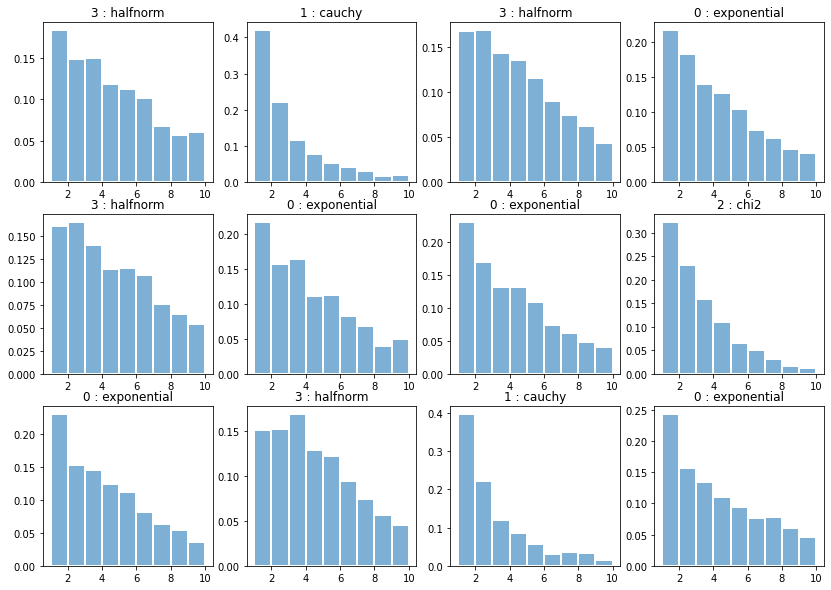

In [ ]:
fig = plt.figure(figsize=(14,10))
plot_densities(X, y, bins, dist_dict, fig, nrow=3, ncol=4, sp=25)
plt.show()

## Typical minimum distance between points


In [ ]:
minimum_distances = []
for i in range(len(X)):
    min_d_i = 1e100
    idx = np.random.randint(0, len(X), 200)
    for j in idx:
        if i != j and min_d_i > js(X[i], X[j]) :
            min_d_i = js(X[i], X[j])
    minimum_distances.append(min_d_i)

typical_min_d     = np.mean(minimum_distances)
typical_min_d_std = np.std(minimum_distances)

print(f"Typical distance between points is {typical_min_d:.5f} +/- {typical_min_d_std:.5f}")


Typical distance between points is 0.00056 +/- 0.00027


## t-SNE

Completed t-SNE with init pca and perplexity 5 in 20.47 s
Completed t-SNE with init pca and perplexity 10 in 18.72 s
Completed t-SNE with init pca and perplexity 20 in 28.59 s
Completed t-SNE with init pca and perplexity 25 in 22.52 s
Completed t-SNE with init pca and perplexity 30 in 25.57 s
Completed t-SNE with init pca and perplexity 40 in 26.01 s
Completed t-SNE with init pca and perplexity 50 in 28.23 s


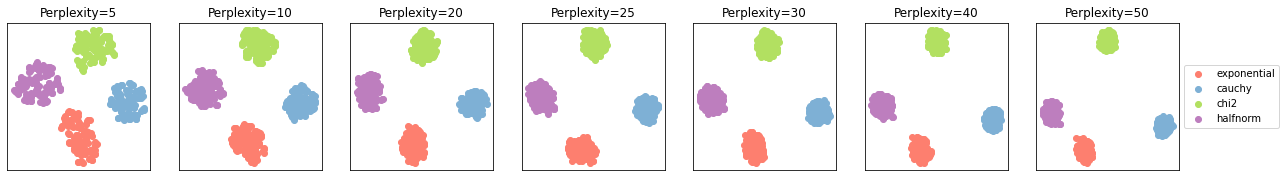

Completed t-SNE with init random and perplexity 5 in 22.50 s
Completed t-SNE with init random and perplexity 10 in 20.54 s
Completed t-SNE with init random and perplexity 20 in 23.11 s
Completed t-SNE with init random and perplexity 25 in 27.92 s
Completed t-SNE with init random and perplexity 30 in 24.26 s
Completed t-SNE with init random and perplexity 40 in 25.32 s
Completed t-SNE with init random and perplexity 50 in 30.43 s


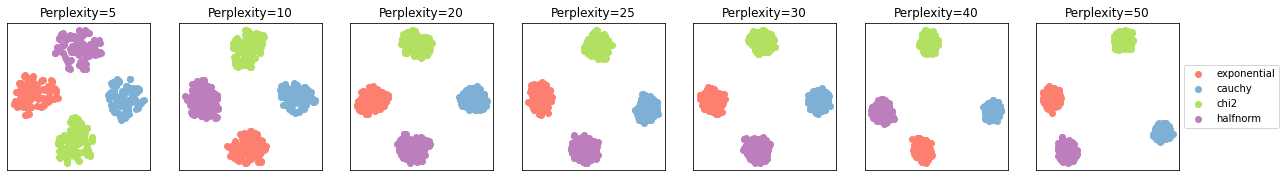

In [ ]:
np.random.seed(0)

# PARAMETERS
n_samples    = N
n_components = 2 
perplexities = [5, 10, 20, 25, 30, 40, 50]
inits        = ["random", "pca"]
Np           = len(perplexities)

# use only a subset of data (time saving)
sub_idx = 1000 # N to use the full dataset

# for each initializer, namely "random" and "pca"
for init in inits:

    # create a figure with one row and Np columns
    (fig, subplots) = plt.subplots(1, Np, figsize=(3*Np, 2.7))
    
    # for each perplexity value
    for i, perplexity in enumerate(perplexities):
        
        ax = subplots[i]

        # run tSNE 
        t0 = time()
        tsne = manifold.TSNE(
            n_components  = n_components,
            init          = init, # "pca", "random"
            random_state  = 0,
            perplexity    = perplexity,
            learning_rate = "auto", 
            metric        = js # !!!
        )
        Y = tsne.fit_transform(np.array(X[:sub_idx]))
        t1 = time()

        # save results (with labels) in a dataframe 
        df = pd.DataFrame(
            {
                "x":Y[:, 0], 
                "y":Y[:, 1], 
                "c":y[:sub_idx]
            }
        )

        # plot results
        ax.set_title("Perplexity=%d" % perplexity)
        for i, dff in df.groupby("c"):
            ax.scatter(dff.x, dff.y, c=colors[i], label=dist_dict[i])

        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

        print(f'Completed t-SNE with init {init} and perplexity {perplexity} in {t1-t0:.2f} s')
        
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

### Answer to exercise 5A.2)

As we read from [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), the `perplexity` is related to the number of nearest neighbors that is used also in other manifold learning algorithms and it is advisable to set it between 5 and 50. The greater the dataset, the greater the perplexity. In particular it fixes the local entropy over all the dataset, which then determines the variance of the distance (measured through the specified metric) between the i-th point and its neighbors, based on the local density of points (high-density regions will have smaller variance).

Taking a look to empirical results we see that patterns in data do not change very much for different values of `perplexity`. Probably this is due to the fact that JS metrics is suitably designed to highlight differences between samples drawn from different PDFs (on the other hand, in exercise 5A the euclidean metric is not able to effectively measure the distance between samples belonging to different datasets), so that a small perplexity is sufficient to effectively separate clusters. If with only 1000 samples `perplexity=5` is sufficient, we saw also that with 5000 samples we have to increase that to 20 in order to have satisfying results, coherently with what the documentation says.
Moreover we note that using `init="random"` or `init="pca"` leads to the same results, as we expected taking into account the figure below: points are distributed approximately as half gaussian, _i.e._ each component carries almost the same amount of information.

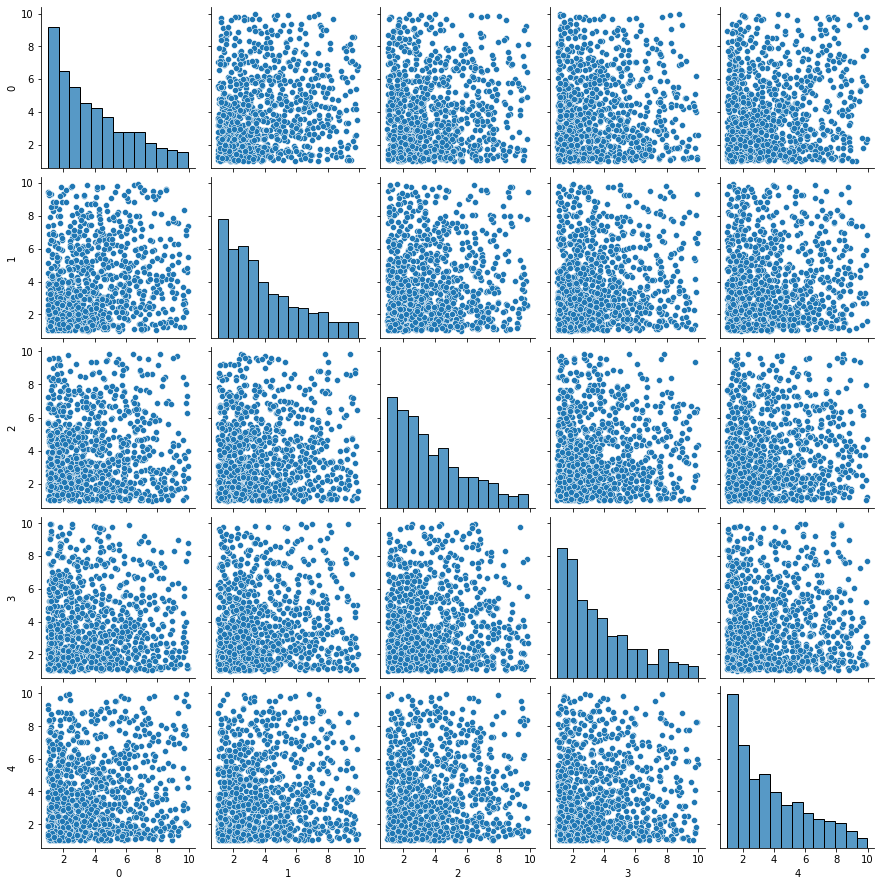

In [ ]:
sns.pairplot(pd.DataFrame(x[:1000, :5]))

## DBSCAN

### On original data with JS metric

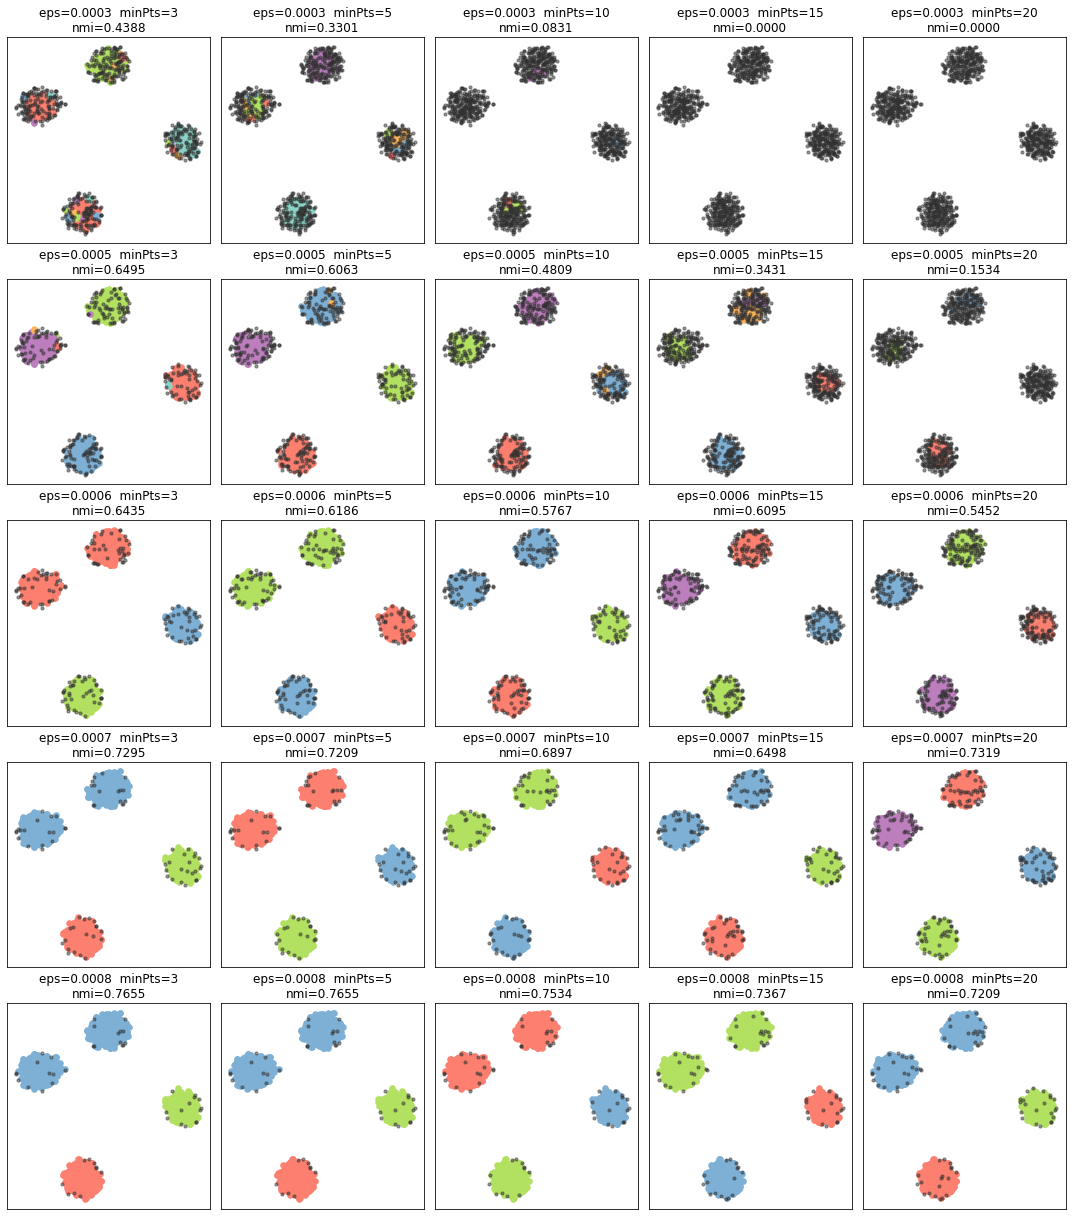

In [ ]:
np.random.seed(12345)

# save tSNE results with perplexity = 50
X2D    = Y 

# save true labels of the subset of data
y_true = y[:sub_idx]

# save the typical distance between points
r = typical_min_d

# parameters GRID
eps_range        = [0.6*r, 0.8*r, r, 1.2*r, 1.4*r]
min_sample_range = [3, 5, 10, 15, 20]


fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,17))

# for each epsilon
for i, eps in enumerate(eps_range):
    # for each minimun number of samples
    for j, min_samples in enumerate(min_sample_range):

        # run DBSCAN
        model = DBSCAN(eps=eps, min_samples=min_samples, metric=js)
        model.fit(np.array(X[:sub_idx])) 
        y_hat = model.labels_ # predicted labels

        # split clusters from noise
        X_l = np.concatenate((X2D, np.expand_dims(y_hat, axis=1)), axis=1)
        clusters = X_l[X_l[:,2] != -1]
        noise    = X_l[X_l[:,2] == -1]

        # plot predicted clusters
        for k, yu in enumerate(np.unique(clusters[:,2])):
            pos = (clusters[:,2] == yu)
            ax[i,j].scatter(
                clusters[pos,0], 
                clusters[pos,1], 
                c=colors[k%len(colors)], 
                s=30
            )

        # plot noise (grey/black points)
        for k, yu in enumerate(np.unique(noise[:,2])):
            pos = (noise[:,2] == yu)
            ax[i,j].scatter(
                noise[pos,0], 
                noise[pos,1], 
                c="#313131", 
                alpha=0.5, 
                s=10
            )

        nmi=normalized_mutual_info_score(y_true, y_hat)
        ax[i,j].set_title('eps=%.4f  minPts=%i\nnmi=%.4f'%(eps,min_samples,nmi))
        ax[i,j].tick_params(left=False,bottom=False)
        ax[i,j].xaxis.set_major_formatter(NullFormatter())
        ax[i,j].yaxis.set_major_formatter(NullFormatter())
        ax[i,j].axis('tight')

plt.tight_layout(h_pad=0.5)
plt.show()

DBSCAN struggles to recognise the four clusters, most of the time it only identifies three of them, and when it detects the correct number of clusters it does so with a lot of noise (black dots).

### On t-SNE data with euclidean metric and answer to 5A.3)

To obtain satisfactory results we can apply DBSCAN on the 2D projected output from t-SNE with the euclidean metric. 

Moreover, we explore the 5A.3) task of the exercise. Given a selected value for the MinPts parameter in DBSCAN we can compute theoptimal value of epsilon using the following procedure [[1]]:

- calculate the average distance between each point and its k nearest neighbors (knn), where k = the MinPts value
- plot the average k-distances in descending order on a k-distance graph
- the optimal value for ε is the point of maximum curvature [[2]]

[1]: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
[2]: https://library.iugaza.edu.ps/thesis/106515.pdf

Before the complete implementation, let's give a template example of the optimal ε value computation procedure for k = 6:

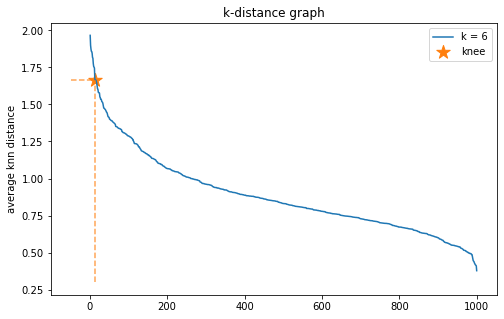

In [ ]:
# template example, k = 6
k = 6

# compute knn distances for each point
nbrs = NearestNeighbors(n_neighbors=k).fit(Y)
distances, indices = nbrs.kneighbors(Y)

# k-distance graph in descending order
distance_desc = sorted(distances[:,k-1], reverse=True)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(1,len(distance_desc)+1)), distance_desc, label=f"k = {k}")

# compute the knee, point where there is a critical change in the distances curve
kneedle = KneeLocator(
                    range(1,len(distance_desc)+1),  
                    distance_desc, 
                    curve="convex", 
                    direction="decreasing")

ax.hlines(kneedle.knee_y, ax.get_xlim()[0], kneedle.knee  , linestyles="dashed", color="tab:orange", alpha=0.7)
ax.vlines(kneedle.knee,   ax.get_ylim()[0], kneedle.knee_y, linestyles="dashed", color="tab:orange", alpha=0.7)
ax.scatter(kneedle.knee, kneedle.knee_y, color="tab:orange", marker="*", s=200, label="knee")

ax.set_title("k-distance graph")
ax.set_ylabel("average knn distance")
ax.legend()

plt.show()

Now let's see how DBSCAN works following the settings described above.

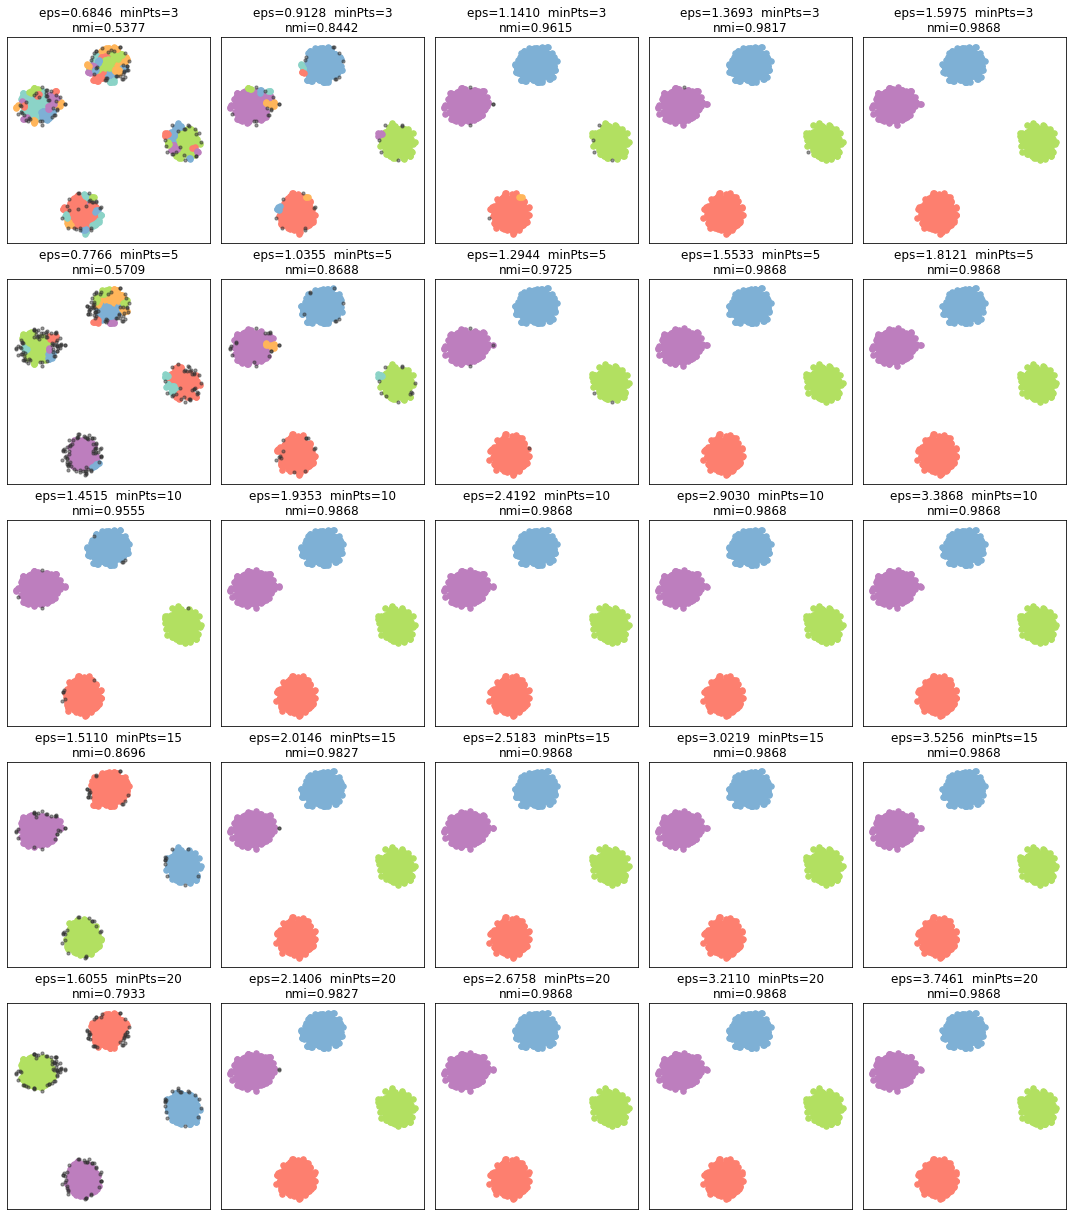

In [ ]:
np.random.seed(12345)

# save tSNE results with perplexity = 50
X2D    = Y 

# save true labels of the subset of data
y_true = y[:sub_idx]

# parameters GRID
min_sample_range = [3, 5, 10, 15, 20] # it must be sorted!

k = np.max(min_sample_range)

# compute knn distances for each point
nbrs = NearestNeighbors(n_neighbors=k).fit(X2D)
distances, indices = nbrs.kneighbors(X2D)

# for the selected values of MinPts pick the expected optimal value for epsilon
eps_list = []
for minp in min_sample_range:
    distance_desc = sorted(distances[:,minp-1], reverse=True)

    # compute the knee, point where there is a critical change in the distances curve
    kneedle = KneeLocator(
                      range(1,len(distance_desc)+1),  
                      distance_desc, 
                      curve="convex", 
                      direction="decreasing") 
    
    eps_list.append(kneedle.knee_y)

fig, ax = plt.subplots(5,len(min_sample_range),figsize=(15,17))

# for each minimun number of samples
for i, min_samples in enumerate(min_sample_range):

    # for each epsilon sweep along the optimal value
    r         = eps_list[i]
    eps_range = [0.6*r, 0.8*r, r, 1.2*r, 1.4*r]
    for j, eps in enumerate(eps_range):

        # run DBSCAN
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(np.array(X2D)) 
        y_hat = model.labels_ # predicted labels

        # split clusters from noise
        X_l = np.concatenate((X2D, np.expand_dims(y_hat, axis=1)), axis=1)
        clusters = X_l[X_l[:,2] != -1]
        noise    = X_l[X_l[:,2] == -1]

        # plot predicted clusters
        for k, yu in enumerate(np.unique(clusters[:,2])):
            pos = (clusters[:,2] == yu)
            ax[i,j].scatter(
                clusters[pos,0], 
                clusters[pos,1], 
                c=colors[k%len(colors)], 
                s=30
            )

        # plot noise (grey/black points)
        for k, yu in enumerate(np.unique(noise[:,2])):
            pos = (noise[:,2] == yu)
            ax[i,j].scatter(
                noise[pos,0], 
                noise[pos,1], 
                c="#313131", 
                alpha=0.5, 
                s=10
            )

        nmi=normalized_mutual_info_score(y_true, y_hat)
        ax[i,j].set_title('eps=%.4f  minPts=%i\nnmi=%.4f'%(eps,min_samples,nmi))
        ax[i,j].tick_params(left=False,bottom=False)
        ax[i,j].xaxis.set_major_formatter(NullFormatter())
        ax[i,j].yaxis.set_major_formatter(NullFormatter())
        ax[i,j].axis('tight')

plt.tight_layout(h_pad=0.5)
plt.show()


Let's focus on specific DBSCAN parameter values that seem to work well.

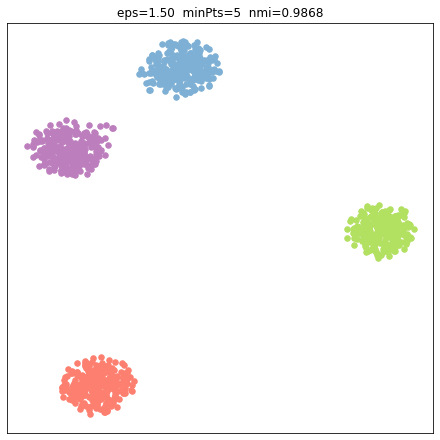

Estimated number of clusters: 4
Estimated number of noise points: 0
Homogeneity: 0.987
Completeness: 0.987


In [ ]:
np.random.seed(12345)
n_true_center=3
X2D = Y # best visualization above
y_true = y[:sub_idx]

eps         = 1.5
min_samples = 5

fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)

model = DBSCAN(eps=eps, min_samples=min_samples)
model.fit(np.array(X2D)) 
y_hat = model.labels_

unique_labels = set(y_hat)

clusters=np.concatenate((X2D, np.expand_dims(y_hat, axis=1)), axis=1)
clusters=clusters[clusters[:,2] != -1]

for i, yu in enumerate(np.unique(clusters[:,2])):
    pos = (clusters[:,2] == yu)
    ax.scatter(clusters[pos,0], clusters[pos,1],c=colors[i%len(colors)], s=30)

nmi=normalized_mutual_info_score(y_true, y_hat)
ax.set_title('eps=%.2f  minPts=%i  nmi=%.4f'%(eps,min_samples,nmi))
ax.tick_params(left=False,bottom=False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')


plt.show()

n_clusters_ = len(set(y_hat)) - (1 if -1 in y_hat else 0)
n_noise_    = list(y_hat).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_true, y_hat))
print("Completeness: %0.3f" % metrics.completeness_score(y_true, y_hat))


Now the four clusters are detected most of the time with a low level of noise. Furthermore, we observe that the procedure to compute the $\epsilon$ DBSCAN parameter given _MinPts_ is pretty accurate.

## Hierarchical Clustering

### On original dataset with JS metric

In [ ]:
# method to calculate distances between all sample pairs
from sklearn.metrics import pairwise_distances
def js_affinity(X):
    return pairwise_distances(X,  metric=js)

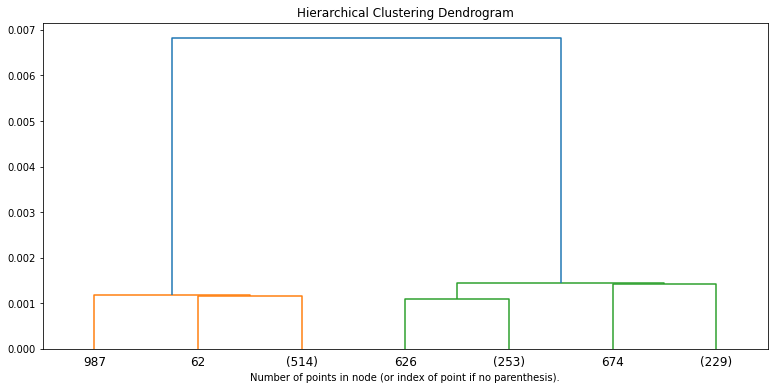

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='single', affinity=js_affinity)

model = model.fit(X[:1000])

plt.figure(figsize=(13,6))
plt.title("Hierarchical Clustering Dendrogram")

plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Running the hierarchical clustering over our dataset it is evident what we have noticed from the previous analysis: there are two clusters that are difficult to distinguish with the used metric. As we can notice from the dendogram only three clusters are detected and the situation doesn't change increasing the number of showed levels. So, what we can do is again to use the projected 2D dataset from t-SNE and perfrom the hierarchical clustering using the euclidian metric.

### On tSNE data with euclidean metric

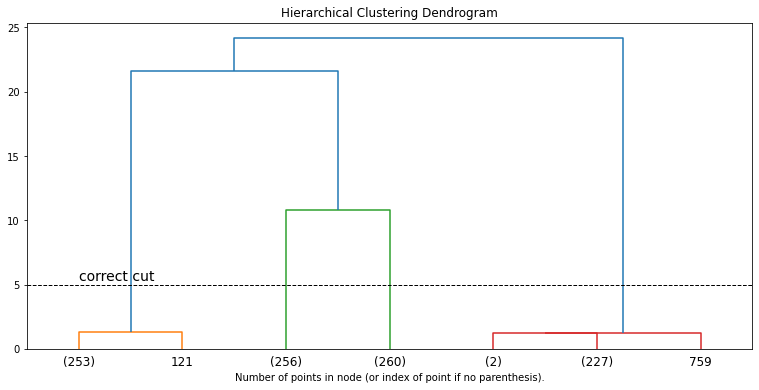

In [ ]:
model1 = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='single')

model1 = model1.fit(X2D)

plt.figure(figsize=(13,6))
plt.title("Hierarchical Clustering Dendrogram")

plot_dendrogram(model1, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(5, color="k", ls="--", lw=1)
plt.annotate("correct cut", xy=(5,5.3), fontsize=14)
plt.show()

Below we try to define a sort of accuracy for the `AgglomerativeClustering` which simply counts the number of points in a cluster which have a different label w.r.t the majority of that cluster. To this purpose we set the number of clusters to be 4, through `distance_threshold` argument (in order to plot the dendogram and see that the model leads to results identical to the previous one).

sort of accuracy: 0.997


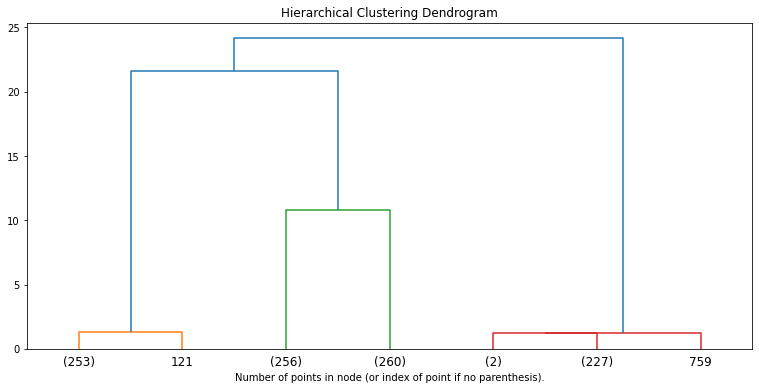

In [ ]:
y_true    = y[:sub_idx]

# define model which stops at 4 clusters
model2 = AgglomerativeClustering(distance_threshold=1.7, n_clusters=None,linkage='single')
model2 = model2.fit(X2D) 

plt.figure(figsize=(13,6))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show

# make predictions and find the correspondence between true labels and predicted ones
y_pred         = model2.fit_predict(X2D)
pred_lbls      = np.unique(y_pred)
pred_true_dict = { i: np.argmax(np.bincount(y_true[y_pred==i])) for i in pred_lbls }

# calculate accuracy
sort_of_accuracy = np.sum([np.sum(y_true[y_pred==i]==pred_true_dict[i]) for i in pred_lbls])/len(y_true)
print('sort of accuracy:', sort_of_accuracy)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>